In [1]:
import bz2
import dill
import matplotlib.pyplot as plt
import numpy as np
import glob, os
import pickle
import ipywidgets as widgets
from ipywidgets import Button, Layout, Dropdown
from lmfit import Model, Parameters
from lmfit.models import PseudoVoigtModel, PolynomialModel, ConstantModel, LinearModel, VoigtModel, GaussianModel
from scipy.interpolate import CubicSpline, splev, splrep
%matplotlib notebook

import inflect
p = inflect.engine()

from xrd_tools import getReflections
from Testing_LMFIT_functions import *

In [2]:
# Generate frames list

# Define paths
data_dir = r'Z:\Diamond_MG28894-1_DATA_BACKUP\rawdata'
cal_dir = r"Z:\Diamond_MG28894-1_DATA_BACKUP\processing"
stacked_data = r"Z:\Diamond_MG28894-1_PROCESSING\Diamond_stacked_data"

scanID = str(108800)

In [ ]:
# with open('Diamond_experiments.pkl', 'rb') as f:
#     Samples = pickle.load(f)
    
# experiment_scanIDs = sorted([str(value[0]) for value in Samples.values() if value[0] != None])

# drop_down = Dropdown(options=experiment_scanIDs, value=experiment_scanIDs[0], description='scanID:', disabled=False, 
#                              layout=Layout(width='40%'), style={'description_width': 'initial'})

# def dropdown_handler(change):
#     global scanID
#     scanID = change.new
# drop_down.observe(dropdown_handler, names='value')
# display(drop_down)

x_max:  3644 	 x_min:  605 	 len_x:  3039 	 len_y:  3039


<IPython.core.display.Javascript object>


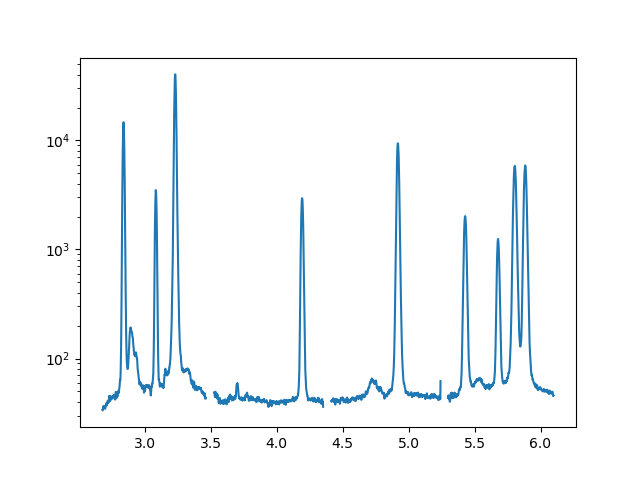

In [3]:
data = np.genfromtxt(stacked_data + "\\0pt8_mask_108800_c9-10-11_compressed.txt").T
data = data[:-3]

### plot diffraction pattern and add horizontal line for each automatically chosen peak & trough
x_min = np.where(data[0][1:]<=2.6815)[0][-1]
x_max = np.where(data[0][1:]>=6.1)[0][0]

x = data[0][x_min:x_max]
y = data[1][x_min:x_max]

print("x_max: ", x_max , "\t x_min: ", x_min, "\t len_x: ", len(x), "\t len_y: ", len(y))
# plt.xlim(2.85, 2.9)
# plt.ylim(5*10**4, 10**5.5)

plt.plot(x, y)
plt.yscale("log")

In [4]:
max_threshold = 500
min_threshold = 80
auto_peaks = list(auto_peak_selector(x, y, max_threshold))
auto_minimums = list(auto_minimum_selector(x, y, min_threshold))

# find maximum for each peak
peak_max = []

for peak in auto_peaks:
    intensitys = [val[1] for val in peak]
    max_y = max(intensitys)
    ymax_twotheta = peak[intensitys.index(max_y)][0]
    peak_max.append((ymax_twotheta, max_y))
    
# find minimum between each peak
trough_mins = []

for peak in auto_minimums:
    intensitys = [val[1] for val in peak]
    min_y = min(intensitys)
    ymin_twotheta = peak[intensitys.index(min_y)][0]
    trough_mins.append((ymin_twotheta, min_y))

print(trough_mins)
    
# remove last minimum where signal is very weak to improve background fit
trough_mins = trough_mins[:-1]

[(2.681188, 33.429392), (3.045688, 45.804667), (3.141313, 53.791689), (3.168313, 70.128307), (3.283063, 77.846953), (3.294313, 74.473824), (3.460813, 43.02831), (3.937813, 35.926782), (4.351813, 36.074688), (4.444063, 37.794926), (5.224813, 41.693731), (5.311438, 40.16781), (5.611813, 52.073987), (5.720938, 58.744636), (6.095563, 45.315454)]


In [5]:
bg_model = ConstantModel(prefix='bg_')
params = bg_model.make_params()
params["bg_c"].set(value=y[0], vary=True, max=y[0])

In [6]:
### parameters for Zr peaks ###

### Zr-Hydride parameters for reverse fit ###
# ZrH111d_min = 2.825; ZrH111d_max = 2.865
# ZrH111g_min = 2.868; ZrH111g_max = 2.89
# ZrH200d_min = 3.271; ZrH200d_max = 3.328
# ZrH200g_min = 3.342; ZrH200g_max = 3.382
# SPP1_min = 3.622 ;SPP1_max = 3.650
# SPP2_min = 3.692; SPP2_max = 3.722
# ZrH220a_min = 4.588; ZrH220a_max = 4.656
# ZrH220b_min = 4.557; ZrH220b_max = 4.595
# ZrH311_min = 5.456; ZrH311_max = 5.495

### Zr-Hydride parameters for forward fit ###
ZrH111d_min = 2.878; ZrH111d_max = 2.915
ZrH111g_min = 2.914; ZrH111g_max = 2.947
ZrH200d_min = 3.306; ZrH200d_max = 3.342; ZrH200d_centre = 3.322
ZrH200g_min = 3.408; ZrH200g_max = 3.428
SPP1_min = 3.692 ;SPP1_max = 3.710
SPP2_min = 3.765; SPP2_max = 3.781
ZrH220a_min = 4.696; ZrH220a_max = 4.749
ZrH220b_min = 4.765; ZrH220b_max = 4.811
ZrH311_min = 5.508; ZrH311_max = 5.549
ZrFeCr_min = 3.15; ZrFeCr_max = 3.17

#########################################################################################

pv_models = {}
# min_y = min(y[50: -50])

for i, maxima in enumerate(auto_peaks):
    
    # generate PseudoVoigtModels for each peak (i.e. maxima range from auto_peak_selector)
    model_key = "pv{0}".format(i+1)
    prefix=model_key+"_"
    pv_models[model_key] = PseudoVoigtModel(prefix=prefix)
    params.update(pv_models[model_key].make_params())
    
    # set initial parameter values
    intensitys = [val[1] for val in maxima]
    max_y = max(intensitys)
    ymax_twotheta = maxima[intensitys.index(max_y)][0]
#     pv_twotheta_max = maxima[-1][0] # set sigma based on min & max ttheta from the auto_peaks function
#     pv_twotheta_min = maxima[0][0]
#     sigma = (pv_twotheta_max-pv_twotheta_min)/4

    sigma = 0.01 # set sigma to known approximate value

    params.add(f"{model_key}_center", value=ymax_twotheta, min=ymax_twotheta-sigma, max=ymax_twotheta+sigma)
    params.add(f"{model_key}_sigma", value=sigma, min=sigma/10, max=sigma*2)
    params.add(f"{model_key}_fraction", value=0.1, min=0.01, max=0.2)

### Add Zr peaks to Zr Model ###
zr_model = bg_model
for key, value in pv_models.items():
    zr_model = zr_model + value

### Fit Zr model ###
zr_init = zr_model.eval(params, x=x)
zr_out = zr_model.fit(y, params, x=x, nan_policy='omit')
zr_comps = zr_out.eval_components(x=x)

In [7]:
# print(zr_out.fit_report())

<IPython.core.display.Javascript object>


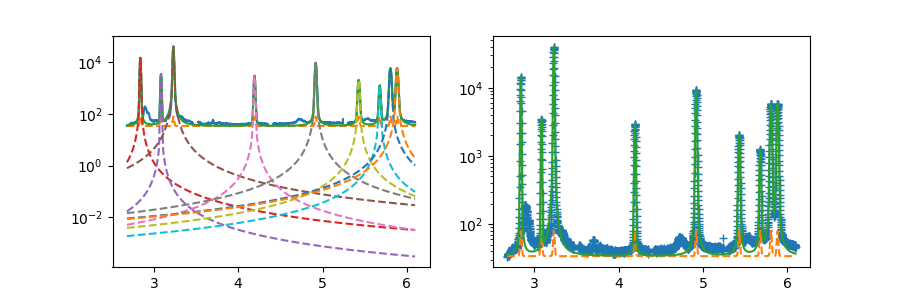

In [8]:
# print(zr_out.params.pretty_print())
interactive_plot_results(x, y, zr_init, zr_out)

## Loop through full experiment

In [9]:
fits = dict()
fits["1"] = [zr_out, zr_comps, zr_out.params]

In [10]:
frames = [int(i) for i in data.T[0][1:]]

fitting frame:  37 	 index:  2


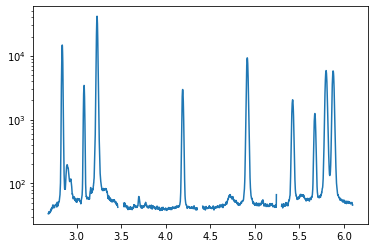

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     205.2     -inf      inf     None     True     None     None
pv1_center        2.837    2.828    2.848     None     True     None     None
pv1_fraction      0.105     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None     True     None     None
pv1_height     1.478e+04     -inf      inf     None     True     None     None
pv1_sigma      0.006337    0.001     0.02     None     True     None     None
pv2_amplitude     49.92     -inf      inf     None     True     None     None
pv2_center        3.082    3.072    3.092     None     True     None     None
pv2_fraction    0.01349     0.01      0.2     None     True     None     None
pv2_fwhm        0.01343     -inf      inf     None     True     None     None
pv2_height         3435     -inf      inf     None     True  

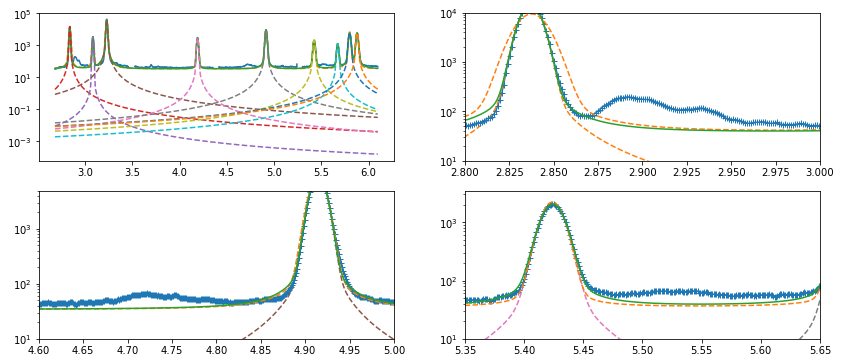

pv1_
1
Warning, fit has changed shape -- doing fit again
max_y:  14697.293457
Warning, fit is still shit
pv2_
2
Warning, fit has changed shape -- doing fit again
max_y:  3423.730598
Warning, fit is still shit
pv3_
3
Warning, fit has changed shape -- doing fit again
max_y:  41520.503418
Warning, fit is still shit
pv4_
4
Warning, fit has changed shape -- doing fit again
max_y:  2958.338974
Warning, fit is still shit
pv5_
5
Warning, fit has changed shape -- doing fit again
max_y:  9265.444458
Warning, fit is still shit
pv6_
6
Warning, fit has changed shape -- doing fit again
max_y:  2045.209972
Warning, fit is still shit
pv7_
7
Warning, fit has changed shape -- doing fit again
max_y:  1244.471706
Warning, fit is still shit
pv8_
8
Warning, fit has changed shape -- doing fit again
max_y:  5853.834869
Warning, fit is still shit
pv9_
9
Warning, fit has changed shape -- doing fit again
max_y:  5777.121597
Warning, fit is still shit
fitting frame:  73 	 index:  3


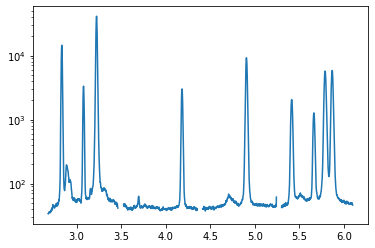

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     199.1     -inf      inf     None     True     None     None
pv1_center        2.832    2.828    2.848     None     True     None     None
pv1_fraction    0.08482     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None     True     None     None
pv1_height     1.478e+04     -inf      inf     None     True     None     None
pv1_sigma      0.006251    0.001     0.02     None     True     None     None
pv2_amplitude     47.72     -inf      inf     None     True     None     None
pv2_center        3.076    3.072    3.092     None     True     None     None
pv2_fraction    0.06912     0.01      0.2     None     True     None     None
pv2_fwhm        0.01343     -inf      inf     None     True     None     None
pv2_height         3435     -inf      inf     None     True  

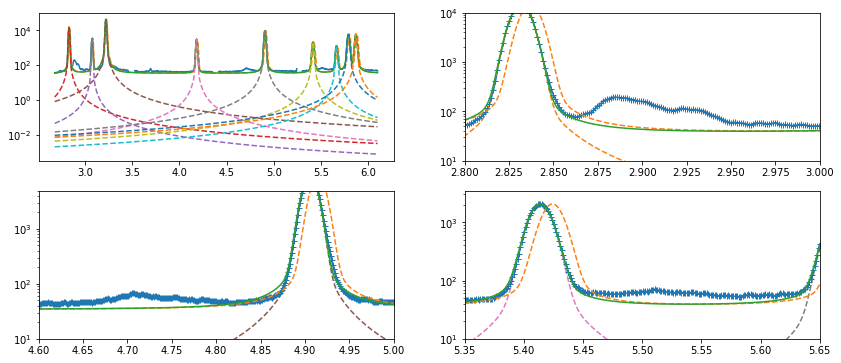

pv1_
1
Warning, fit has changed shape -- doing fit again
max_y:  14494.223785
Warning, fit is still shit
pv2_
2
Warning, fit has changed shape -- doing fit again
max_y:  3316.763802
Warning, fit is still shit
pv3_
3
Warning, fit has changed shape -- doing fit again
max_y:  41139.384766
Warning, fit is still shit
pv4_
4
Warning, fit has changed shape -- doing fit again
max_y:  3002.328758
Warning, fit is still shit
pv5_
5
Warning, fit has changed shape -- doing fit again
max_y:  9214.391479
Warning, fit is still shit
pv6_
6
Warning, fit has changed shape -- doing fit again
max_y:  2048.36755
Warning, fit is still shit
pv7_
7
Warning, fit has changed shape -- doing fit again
max_y:  1267.947628
Warning, fit is still shit
pv8_
8
Warning, fit has changed shape -- doing fit again
max_y:  5718.835785
Warning, fit is still shit
pv9_
9
Warning, fit has changed shape -- doing fit again
max_y:  5842.204483
Warning, fit is still shit
fitting frame:  109 	 index:  4


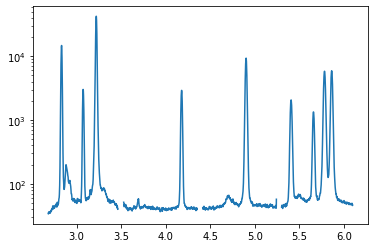

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     198.4     -inf      inf     None     True     None     None
pv1_center        2.829    2.822    2.842     None     True     None     None
pv1_fraction    0.09767     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None     True     None     None
pv1_height     1.478e+04     -inf      inf     None     True     None     None
pv1_sigma      0.006183    0.001     0.02     None     True     None     None
pv2_amplitude     45.48     -inf      inf     None     True     None     None
pv2_center        3.072    3.066    3.086     None     True     None     None
pv2_fraction    0.04747     0.01      0.2     None     True     None     None
pv2_fwhm        0.01343     -inf      inf     None     True     None     None
pv2_height         3435     -inf      inf     None     True  

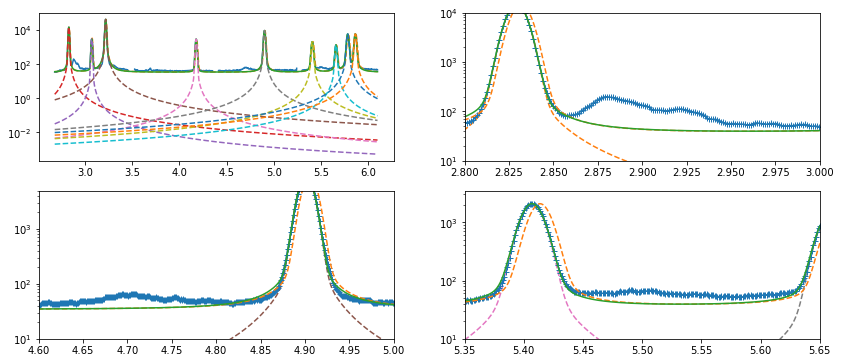

pv1_
1
Warning, fit has changed shape -- doing fit again
max_y:  14689.8349
Warning, fit is still shit
pv2_
2
Warning, fit has changed shape -- doing fit again
max_y:  3009.582199
Warning, fit is still shit
pv3_
3
Warning, fit has changed shape -- doing fit again
max_y:  42217.341919
Warning, fit is still shit
pv4_
4
Warning, fit has changed shape -- doing fit again
max_y:  2910.494003
Warning, fit is still shit
pv5_
5
Warning, fit has changed shape -- doing fit again
max_y:  9301.00885
Warning, fit is still shit
pv6_
6
Warning, fit has changed shape -- doing fit again
max_y:  2058.66843
Warning, fit is still shit
pv7_
7
Warning, fit has changed shape -- doing fit again
max_y:  1334.144585
Warning, fit is still shit
pv8_
8
Warning, fit has changed shape -- doing fit again
max_y:  5791.355133
Warning, fit is still shit
pv9_
9
Warning, fit has changed shape -- doing fit again
max_y:  5903.32515
Warning, fit is still shit
fitting frame:  145 	 index:  5


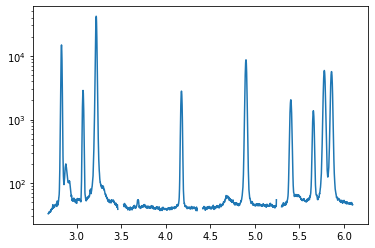

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     204.7     -inf      inf     None     True     None     None
pv1_center        2.828     2.82     2.84     None     True     None     None
pv1_fraction     0.1235     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None     True     None     None
pv1_height     1.478e+04     -inf      inf     None     True     None     None
pv1_sigma      0.006231    0.001     0.02     None     True     None     None
pv2_amplitude      43.8     -inf      inf     None     True     None     None
pv2_center        3.071    3.062    3.082     None     True     None     None
pv2_fraction    0.01024     0.01      0.2     None     True     None     None
pv2_fwhm        0.01343     -inf      inf     None     True     None     None
pv2_height         3435     -inf      inf     None     True  

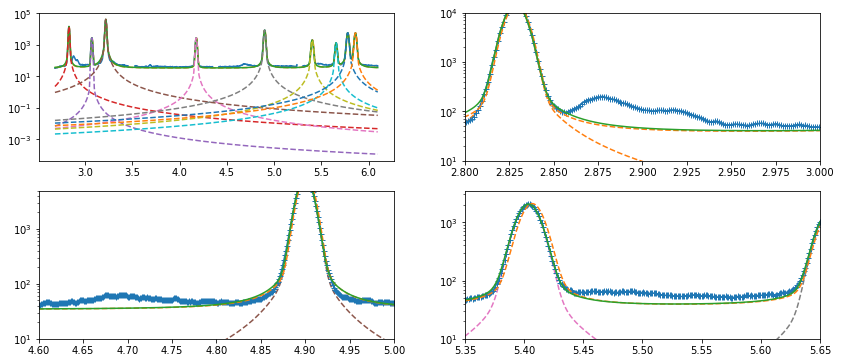

pv1_
1
Warning, fit has changed shape -- doing fit again
max_y:  14823.938232
Warning, fit is still shit
pv2_
2
Warning, fit has changed shape -- doing fit again
max_y:  2862.948189
Warning, fit is still shit
pv3_
3
Warning, fit has changed shape -- doing fit again
max_y:  41860.006592
Warning, fit is still shit
pv4_
4
Warning, fit has changed shape -- doing fit again
max_y:  2789.411491
Warning, fit is still shit
pv5_
5
Warning, fit has changed shape -- doing fit again
max_y:  8667.960953
Warning, fit is still shit
pv6_
6
Warning, fit has changed shape -- doing fit again
max_y:  2042.983261
Warning, fit is still shit
pv7_
7
Warning, fit has changed shape -- doing fit again
max_y:  1373.437305
Warning, fit is still shit
pv8_
8
Warning, fit has changed shape -- doing fit again
max_y:  5883.771683
Warning, fit is still shit
pv9_
9
Warning, fit has changed shape -- doing fit again
max_y:  5655.339142
Warning, fit is still shit
fitting frame:  181 	 index:  6


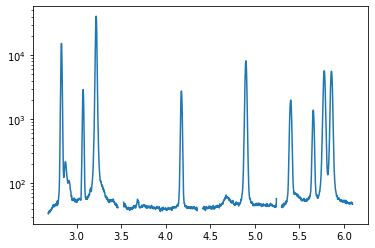

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     217.6     -inf      inf     None     True     None     None
pv1_center        2.828    2.819    2.839     None     True     None     None
pv1_fraction     0.1502     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None     True     None     None
pv1_height     1.478e+04     -inf      inf     None     True     None     None
pv1_sigma      0.006334    0.001     0.02     None     True     None     None
pv2_amplitude     46.14     -inf      inf     None     True     None     None
pv2_center        3.071     3.06     3.08     None     True     None     None
pv2_fraction     0.0441     0.01      0.2     None     True     None     None
pv2_fwhm        0.01343     -inf      inf     None     True     None     None
pv2_height         3435     -inf      inf     None     True  

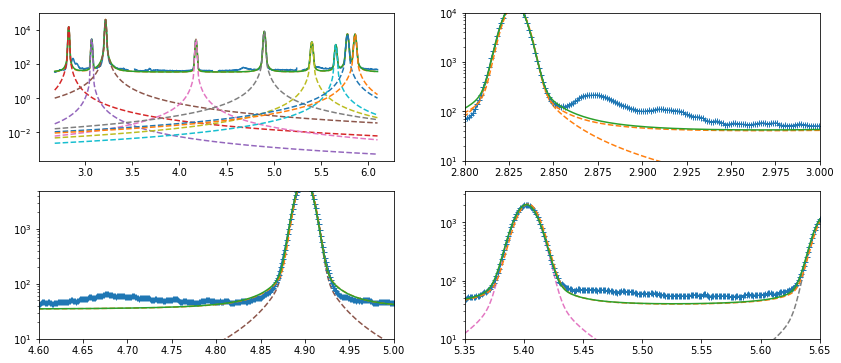

pv1_
1
Warning, fit has changed shape -- doing fit again
max_y:  15241.637787
Warning, fit is still shit
pv2_
2
Warning, fit has changed shape -- doing fit again
max_y:  2898.735046
Warning, fit is still shit
pv3_
3
Warning, fit has changed shape -- doing fit again
max_y:  40500.811035
Warning, fit is still shit
pv4_
4
Warning, fit has changed shape -- doing fit again
max_y:  2753.461105
Warning, fit is still shit
pv5_
5
Warning, fit has changed shape -- doing fit again
max_y:  8165.044739
Warning, fit is still shit
pv6_
6
Warning, fit has changed shape -- doing fit again
max_y:  1990.278709
Warning, fit is still shit
pv7_
7
Warning, fit has changed shape -- doing fit again
max_y:  1386.706696
Warning, fit is still shit
pv8_
8
Warning, fit has changed shape -- doing fit again
max_y:  5703.742584
Warning, fit is still shit
pv9_
9
Warning, fit has changed shape -- doing fit again
max_y:  5602.888397
Warning, fit is still shit
fitting frame:  217 	 index:  7


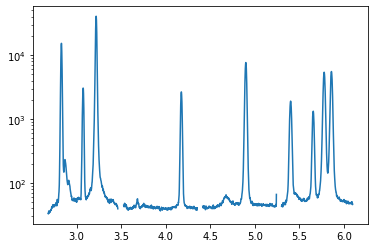

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     225.8     -inf      inf     None     True     None     None
pv1_center        2.828    2.819    2.839     None     True     None     None
pv1_fraction      0.166     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None     True     None     None
pv1_height     1.478e+04     -inf      inf     None     True     None     None
pv1_sigma      0.006509    0.001     0.02     None     True     None     None
pv2_amplitude     48.68     -inf      inf     None     True     None     None
pv2_center        3.072     3.06     3.08     None     True     None     None
pv2_fraction    0.04977     0.01      0.2     None     True     None     None
pv2_fwhm        0.01343     -inf      inf     None     True     None     None
pv2_height         3435     -inf      inf     None     True  

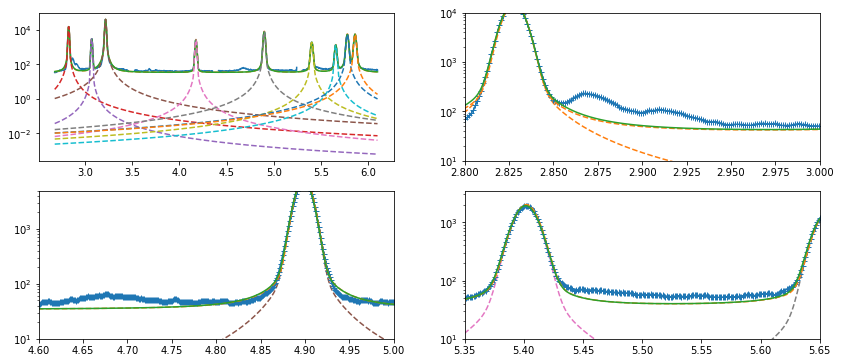

pv1_
1
Warning, fit has changed shape -- doing fit again
max_y:  15293.614258
Warning, fit is still shit
pv2_
2
Warning, fit has changed shape -- doing fit again
max_y:  3051.797295
Warning, fit is still shit
pv3_
3
Warning, fit has changed shape -- doing fit again
max_y:  40581.934937
Warning, fit is still shit
pv4_
4
Warning, fit has changed shape -- doing fit again
max_y:  2658.423157
Warning, fit is still shit
pv5_
5
Warning, fit has changed shape -- doing fit again
max_y:  7654.270981
Warning, fit is still shit
pv6_
6
Warning, fit has changed shape -- doing fit again
max_y:  1906.548882
Warning, fit is still shit
pv7_
7
Warning, fit has changed shape -- doing fit again
max_y:  1326.697742
Warning, fit is still shit
pv8_
8
Warning, fit has changed shape -- doing fit again
max_y:  5403.736359
Warning, fit is still shit
pv9_
9
Warning, fit has changed shape -- doing fit again
max_y:  5542.503693
Warning, fit is still shit
fitting frame:  253 	 index:  8


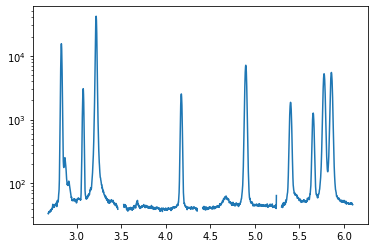

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     233.3     -inf      inf     None     True     None     None
pv1_center        2.827    2.817    2.837     None     True     None     None
pv1_fraction     0.1828     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None     True     None     None
pv1_height     1.478e+04     -inf      inf     None     True     None     None
pv1_sigma      0.006626    0.001     0.02     None     True     None     None
pv2_amplitude     48.25     -inf      inf     None     True     None     None
pv2_center        3.072    3.062    3.082     None     True     None     None
pv2_fraction    0.07405     0.01      0.2     None     True     None     None
pv2_fwhm        0.01343     -inf      inf     None     True     None     None
pv2_height         3435     -inf      inf     None     True  

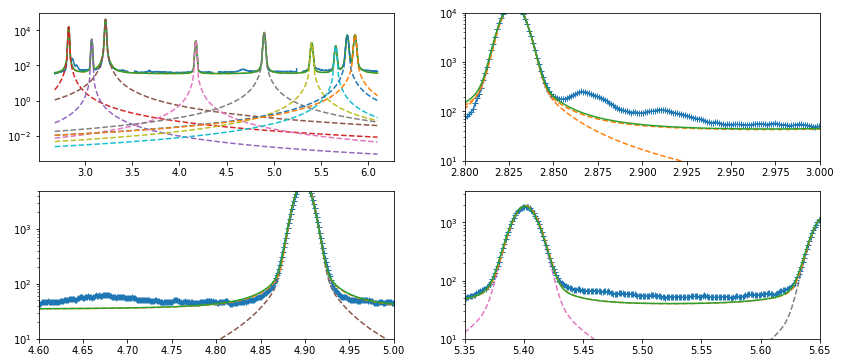

pv1_
1
Warning, fit has changed shape -- doing fit again
max_y:  15468.170959
Warning, fit is still shit
pv2_
2
Warning, fit has changed shape -- doing fit again
max_y:  3052.318657
Warning, fit is still shit
pv3_
3
Warning, fit has changed shape -- doing fit again
max_y:  41697.077515
Warning, fit is still shit
pv4_
4
Warning, fit has changed shape -- doing fit again
max_y:  2524.851715
Warning, fit is still shit
pv5_
5
Warning, fit has changed shape -- doing fit again
max_y:  7099.741135
Warning, fit is still shit
pv6_
6
Warning, fit has changed shape -- doing fit again
max_y:  1862.942097
Warning, fit is still shit
pv7_
7
Warning, fit has changed shape -- doing fit again
max_y:  1264.458214
Warning, fit is still shit
pv8_
8
Warning, fit has changed shape -- doing fit again
max_y:  5237.429916
Warning, fit is still shit
pv9_
9
Warning, fit has changed shape -- doing fit again
max_y:  5477.453995
Warning, fit is still shit
fitting frame:  289 	 index:  9


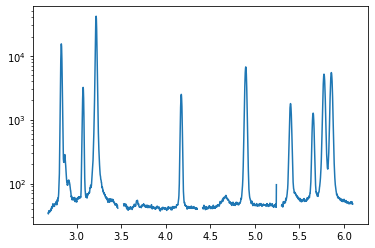

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     233.4     -inf      inf     None     True     None     None
pv1_center        2.827    2.817    2.837     None     True     None     None
pv1_fraction     0.1848     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None     True     None     None
pv1_height     1.478e+04     -inf      inf     None     True     None     None
pv1_sigma      0.006625    0.001     0.02     None     True     None     None
pv2_amplitude     48.23     -inf      inf     None     True     None     None
pv2_center        3.072    3.062    3.082     None     True     None     None
pv2_fraction    0.07308     0.01      0.2     None     True     None     None
pv2_fwhm        0.01343     -inf      inf     None     True     None     None
pv2_height         3435     -inf      inf     None     True  

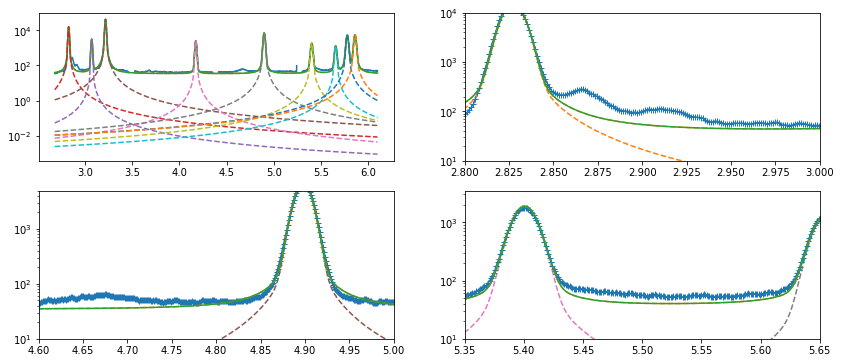

pv1_
1
Warning, fit has changed shape -- doing fit again
max_y:  15384.734314
Warning, fit is still shit
pv2_
2
Warning, fit has changed shape -- doing fit again
max_y:  3201.730721
Warning, fit is still shit
pv3_
3
Warning, fit has changed shape -- doing fit again
max_y:  41668.224609
Warning, fit is still shit
pv4_
4
Warning, fit has changed shape -- doing fit again
max_y:  2485.444611
Warning, fit is still shit
pv5_
5
Warning, fit has changed shape -- doing fit again
max_y:  6697.567688
Warning, fit is still shit
pv6_
6
Warning, fit has changed shape -- doing fit again
max_y:  1784.235729
Warning, fit is still shit
pv7_
7
Warning, fit has changed shape -- doing fit again
max_y:  1263.753239
Warning, fit is still shit
pv8_
8
Warning, fit has changed shape -- doing fit again
max_y:  5157.702072
Warning, fit is still shit
pv9_
9
Warning, fit has changed shape -- doing fit again
max_y:  5461.900772
Warning, fit is still shit
fitting frame:  325 	 index:  10


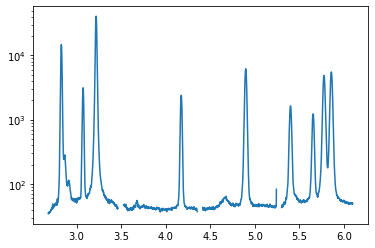

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     241.1     -inf      inf     None     True     None     None
pv1_center        2.827    2.816    2.836     None     True     None     None
pv1_fraction      0.195     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None     True     None     None
pv1_height     1.478e+04     -inf      inf     None     True     None     None
pv1_sigma      0.006875    0.001     0.02     None     True     None     None
pv2_amplitude     51.15     -inf      inf     None     True     None     None
pv2_center        3.071    3.062    3.082     None     True     None     None
pv2_fraction     0.1145     0.01      0.2     None     True     None     None
pv2_fwhm        0.01343     -inf      inf     None     True     None     None
pv2_height         3435     -inf      inf     None     True  

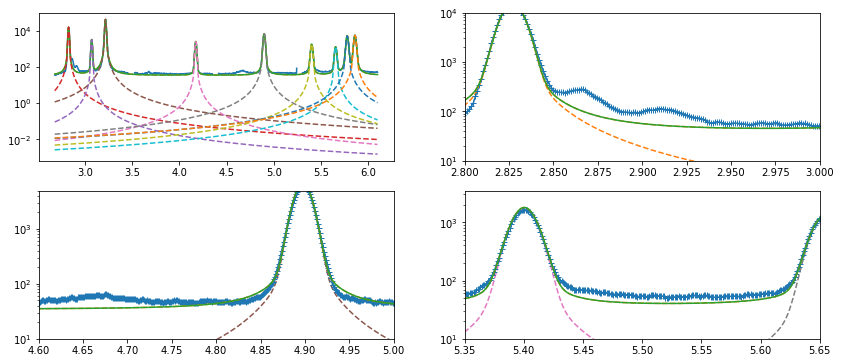

pv1_
1
Warning, fit has changed shape -- doing fit again
max_y:  14750.899628
Warning, fit is still shit
pv2_
2
Warning, fit has changed shape -- doing fit again
max_y:  3137.103828
Warning, fit is still shit
pv3_
3
Warning, fit has changed shape -- doing fit again
max_y:  40743.255615
Warning, fit is still shit
pv4_
4
Warning, fit has changed shape -- doing fit again
max_y:  2403.448074
Warning, fit is still shit
pv5_
5
Warning, fit has changed shape -- doing fit again
max_y:  6195.69278
Warning, fit is still shit
pv6_
6
Warning, fit has changed shape -- doing fit again
max_y:  1642.572197
Warning, fit is still shit
pv7_
7
Warning, fit has changed shape -- doing fit again
max_y:  1232.675968
Warning, fit is still shit
pv8_
8
Warning, fit has changed shape -- doing fit again
max_y:  4891.756592
Warning, fit is still shit
pv9_
9
Warning, fit has changed shape -- doing fit again
max_y:  5527.507858
Warning, fit is still shit
fitting frame:  361 	 index:  11


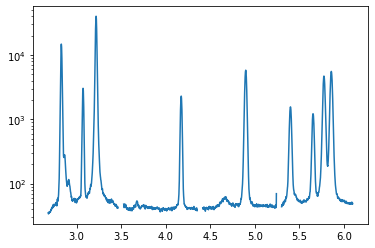

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     242.3     -inf      inf     None     True     None     None
pv1_center        2.827    2.816    2.836     None     True     None     None
pv1_fraction     0.1894     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None     True     None     None
pv1_height     1.478e+04     -inf      inf     None     True     None     None
pv1_sigma      0.007216    0.001     0.02     None     True     None     None
pv2_amplitude     50.84     -inf      inf     None     True     None     None
pv2_center        3.071    3.062    3.082     None     True     None     None
pv2_fraction     0.1235     0.01      0.2     None     True     None     None
pv2_fwhm        0.01343     -inf      inf     None     True     None     None
pv2_height         3435     -inf      inf     None     True  

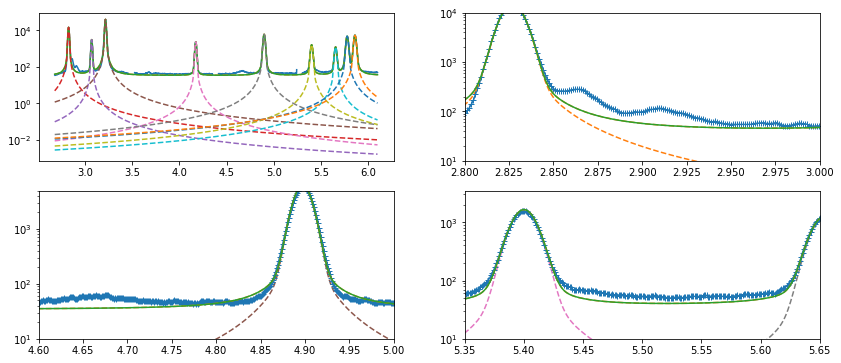

pv1_
1
Warning, fit has changed shape -- doing fit again
max_y:  14815.025177
Warning, fit is still shit
pv2_
2
Warning, fit has changed shape -- doing fit again
max_y:  3041.464264
Warning, fit is still shit
pv3_
3
Warning, fit has changed shape -- doing fit again
max_y:  40163.802246
Warning, fit is still shit
pv4_
4
Warning, fit has changed shape -- doing fit again
max_y:  2301.242798
Warning, fit is still shit
pv5_
5
Warning, fit has changed shape -- doing fit again
max_y:  5819.919083
Warning, fit is still shit
pv6_
6
Warning, fit has changed shape -- doing fit again
max_y:  1564.668278
Warning, fit is still shit
pv7_
7
Warning, fit has changed shape -- doing fit again
max_y:  1223.575615
Warning, fit is still shit
pv8_
8
Warning, fit has changed shape -- doing fit again
max_y:  4704.666183
Warning, fit is still shit
pv9_
9
Warning, fit has changed shape -- doing fit again
max_y:  5570.843918
Warning, fit is still shit
fitting frame:  397 	 index:  12


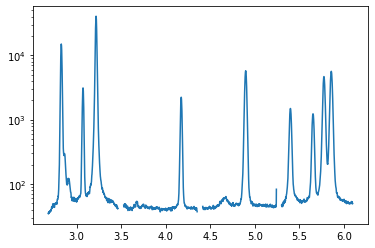

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     254.2     -inf      inf     None     True     None     None
pv1_center        2.827    2.816    2.836     None     True     None     None
pv1_fraction        0.2     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None     True     None     None
pv1_height     1.478e+04     -inf      inf     None     True     None     None
pv1_sigma      0.007455    0.001     0.02     None     True     None     None
pv2_amplitude     52.66     -inf      inf     None     True     None     None
pv2_center         3.07     3.06     3.08     None     True     None     None
pv2_fraction     0.1676     0.01      0.2     None     True     None     None
pv2_fwhm        0.01343     -inf      inf     None     True     None     None
pv2_height         3435     -inf      inf     None     True  

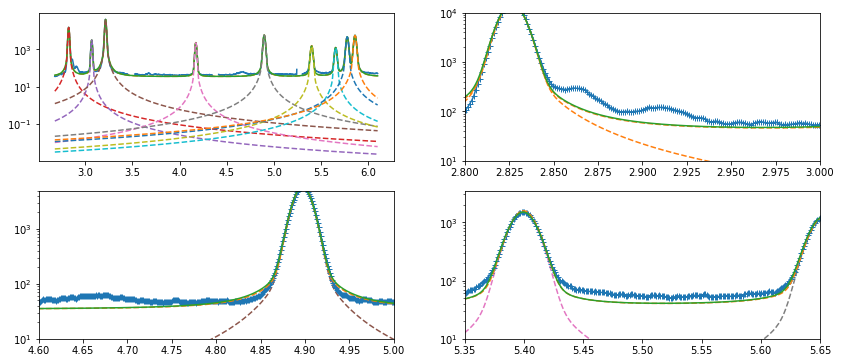

pv1_
1
Warning, fit has changed shape -- doing fit again
max_y:  15003.463196
Warning, fit is still shit
pv2_
2
Warning, fit has changed shape -- doing fit again
max_y:  3119.641228
Warning, fit is still shit
pv3_
3
Warning, fit has changed shape -- doing fit again
max_y:  40560.592041
Warning, fit is still shit
pv4_
4
Warning, fit has changed shape -- doing fit again
max_y:  2234.423241
Warning, fit is still shit
pv5_
5
Warning, fit has changed shape -- doing fit again
max_y:  5772.442612
Warning, fit is still shit
pv6_
6
Warning, fit has changed shape -- doing fit again
max_y:  1495.248409
Warning, fit is still shit
pv7_
7
Warning, fit has changed shape -- doing fit again
max_y:  1234.337193
Warning, fit is still shit
pv8_
8
Warning, fit has changed shape -- doing fit again
max_y:  4678.172333
Warning, fit is still shit
pv9_
9
Warning, fit has changed shape -- doing fit again
max_y:  5649.524277
Warning, fit is still shit
fitting frame:  433 	 index:  13


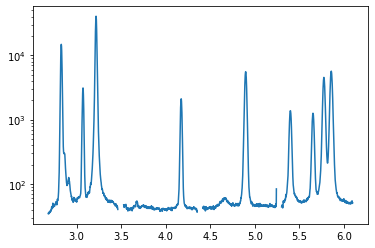

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     254.2     -inf      inf     None     True     None     None
pv1_center        2.827    2.816    2.836     None     True     None     None
pv1_fraction        0.2     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None     True     None     None
pv1_height     1.478e+04     -inf      inf     None     True     None     None
pv1_sigma      0.007455    0.001     0.02     None     True     None     None
pv2_amplitude     52.67     -inf      inf     None     True     None     None
pv2_center         3.07     3.06     3.08     None     True     None     None
pv2_fraction     0.1681     0.01      0.2     None     True     None     None
pv2_fwhm        0.01343     -inf      inf     None     True     None     None
pv2_height         3435     -inf      inf     None     True  

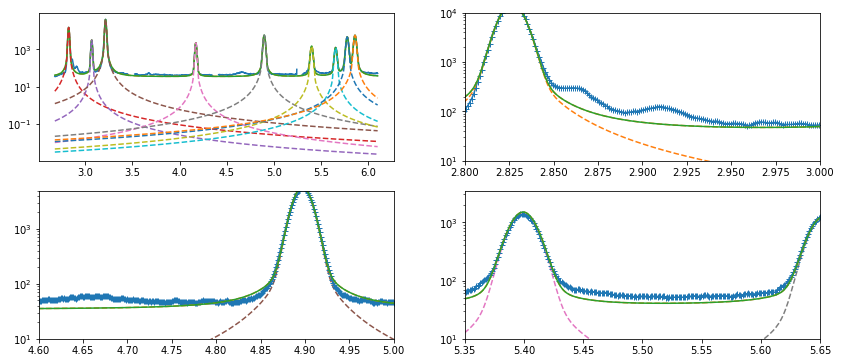

pv1_
1
Warning, fit has changed shape -- doing fit again
max_y:  14810.191345
Warning, fit is still shit
pv2_
2
Warning, fit has changed shape -- doing fit again
max_y:  3107.87236
Warning, fit is still shit
pv3_
3
Warning, fit has changed shape -- doing fit again
max_y:  40522.190186
Warning, fit is still shit
pv4_
4
Warning, fit has changed shape -- doing fit again
max_y:  2108.644333
Warning, fit is still shit
pv5_
5
Warning, fit has changed shape -- doing fit again
max_y:  5560.834122
Warning, fit is still shit
pv6_
6
Warning, fit has changed shape -- doing fit again
max_y:  1377.134758
Warning, fit is still shit
pv7_
7
Warning, fit has changed shape -- doing fit again
max_y:  1256.131516
Warning, fit is still shit
pv8_
8
Warning, fit has changed shape -- doing fit again
max_y:  4532.99234
Warning, fit is still shit
pv9_
9
Warning, fit has changed shape -- doing fit again
max_y:  5665.03273
Warning, fit is still shit
fitting frame:  469 	 index:  14


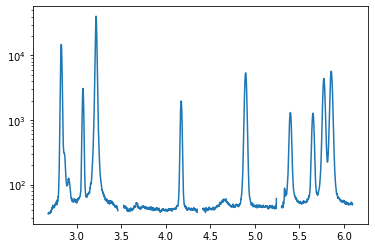

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     255.7     -inf      inf     None     True     None     None
pv1_center        2.826    2.816    2.836     None     True     None     None
pv1_fraction        0.2     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None     True     None     None
pv1_height     1.478e+04     -inf      inf     None     True     None     None
pv1_sigma      0.007601    0.001     0.02     None     True     None     None
pv2_amplitude     53.59     -inf      inf     None     True     None     None
pv2_center         3.07     3.06     3.08     None     True     None     None
pv2_fraction     0.1775     0.01      0.2     None     True     None     None
pv2_fwhm        0.01343     -inf      inf     None     True     None     None
pv2_height         3435     -inf      inf     None     True  

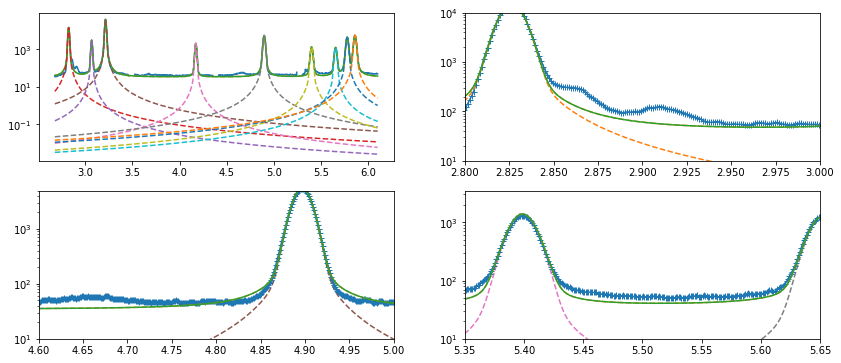

pv1_
1
Warning, fit has changed shape -- doing fit again
max_y:  14732.746338
Warning, fit is still shit
pv2_
2
Warning, fit has changed shape -- doing fit again
max_y:  3077.839134
Warning, fit is still shit
pv3_
3
Warning, fit has changed shape -- doing fit again
max_y:  40384.332642
Warning, fit is still shit
pv4_
4
Warning, fit has changed shape -- doing fit again
max_y:  1968.675709


In [ ]:
### fit Zr peaks over full experiment

%matplotlib inline

previous_params = zr_out.params

### set all parameters to vary ####
for param in previous_params:
    previous_params[param].set(vary=True)

for i, frame in enumerate(list(frames)[1:]): #  fit from next frame in list
    ### load data and plot 
#     test = stacked_data + "\\" + str(scanID) + "0pt8_mask_108800_c9-10-11_compressed.txt"
    test = stacked_data + "\\" + "0pt8_mask_108800_c9-10-11_compressed.txt"

    data = np.genfromtxt(test).T
    ### remove final three frames as these do not contain data for 108800
    data = data[:-3]

    ### slice ttheta range
    x_min = np.where(data[0][1:]<=2.6815)[0][-1]
    x_max = np.where(data[0][1:]>=6.1)[0][0]

    print("fitting frame: ", frame, "\t index: ", i+2)
    x = data[0][x_min:x_max]
    y = data[i+2][x_min:x_max]
    plt.plot(x, y)
    plt.yscale("log")
    plt.show()

    ### do model ###
    init = zr_model.eval(previous_params, x=x)
    out = zr_model.fit(y, previous_params, x=x, nan_policy='omit')
    comps = out.eval_components(x=x)
    ### print all parameters ###
    out.params.pretty_print()
    ### plot results ###
    plot_results(x, y, init, out)

### check if the fit has varied much from the previous fit ###
    for component in out.model.components[1:]:
        ### hackey way to return peak index from prefix i.e. pv1_ = 1 = 1st peak (index_pos 0 in autopeaks!)###
        print(component.prefix)
        peak_i = int(re.search(r'\d+', component.prefix).group())
        print(peak_i)

        any(previous_params[param].value*0.95 <= out.params[param].value <= previous_params[param].value*1.05 for 
            param in component._param_names if "centre" and "bg" not in param) == True
        print("Warning, fit has changed shape -- doing fit again")

        ### find all Zr peaks above threshold ###
        auto_peaks = list(auto_peak_selector(x, y, max_threshold))
        tmp_params = previous_params

        ### find zr peak center for indexed peak & set initial parameters ###
        for i, maxima in enumerate(auto_peaks[peak_i-1:peak_i]):

            # set initial parameter values
            intensitys = [val[1] for val in maxima]
            max_y = max(intensitys)
            print("max_y: ", max_y)
            ymax_twotheta = maxima[intensitys.index(max_y)][0]
            sigma = 0.01 # set sigma to known approximate value

            tmp_params[component.prefix + "center"].set(value=ymax_twotheta, min=ymax_twotheta-sigma, max=ymax_twotheta+sigma)
            tmp_params[component.prefix + "sigma"].set(value=sigma, min=sigma/10, max=sigma*2)
            tmp_params[component.prefix + "fraction"].set(value=0.1, min=0.01, max=0.2)

        ### perform fit ###
        init = zr_model.eval(tmp_params, x=x)
        out = zr_model.fit(y, tmp_params, x=x, nan_policy='omit')
        comps = out.eval_components(x=x)
        
        any(previous_params[param].value*0.98 <= out.params[param].value <= previous_params[param].value*1.02 for 
            param in component._param_names if "centre" and "bg" not in param) == True
        print("Warning, fit is still more than 5% different...")

        ### update the peak_centre, & min & max boundaries buy peak shift as parameters guess for next fit ###            
        if "center" in param:
            ### calc movement of peak centre ### 
            if out.params[param].value == previous_params[param].value:
                print("Warning - likelyhood of poor fit for " + param + ". \n Old centre position = " + f"{previous_params[param].value:.2e}" +
                      "\n new centre position = " + f"{out.params[param].value:.2e}")
#                 increment = increment #use previous increment value
#                 centre_value = out.params[param].value
#                 centre_min = out.params[param].min
#                 centre_max = out.params[param].max
#                 print("\t" + param, "Centre = ", f"{centre_value:.2e}", "Increment = ", f"{increment:.2e}",
#                       "Min = ", f"{centre_min:.2e}", "Max = ", f"{centre_max:.2e}")
#                 ### update the new parameter min & max by increment ###
#                 out.params[param].set(value= centre_value + increment, min= centre_min + increment, max= centre_max + increment)
        
            if out.params[param].value != previous_params[param].value:
                increment = out.params[param].value - previous_params[param].value
                centre_value = out.params[param].value
                centre_min = out.params[param].min
                centre_max = out.params[param].max
                print("\t Fit centers " + param, "Centre = ", f"{centre_value:.2e}", "Increment = ", f"{increment:.2e}",
                      "Min = ", f"{centre_min:.2e}", "Max = ", f"{centre_max:.2e}")                
                
                ### update expected centre value & limits
                out.params[param].set(value= centre_value + increment, min= centre_min - increment, max= centre_max + increment)        
                
                ### check centre is not hitting limits ###
                if centre_value <= centre_min+0.001:
                    print("Warning: ", param, "peak centre has reached lower limit")
                if centre_value >= centre_max+0.001:
                    print("Warning: ", param, "peak centre has reached upper limit")
    #                     out.params[param].set(value= centre_value + increment, min= centre_min + increment, max= centre_max + increment*2)        
                    
    ### update parameters to new parameters
    previous_params = out.params
    
    ### add to dictionary ###
    fits[str(frame)] = [out, comps, previous_params]
    
%matplotlib notebook

In [60]:
print(frames)

[1, 37, 73, 109, 145, 181, 217, 253, 289, 325, 361, 397, 433, 469, 505, 541, 577]


In [62]:
fits.keys()

dict_keys(['1', '37', '73', '109', '145', '181', '217', '253', '289', '325', '361', '397', '433', '469', '505', '541', '577'])

In [67]:
Zr_100_centers = []
Zr_xxx_centers = []

for key, var in fits.items():
    if "pv1_center" in var[0].params:
        Zr_100_centers.append(var[0].params["pv1_center"].value)
    if "pv7_center" in var[0].params:
        Zr_xxx_centers.append(var[0].params["pv7_center"].value)

Zr_100_d_centers = [] 

for ttheta in Zr_100_centers:
    d = 0.141565 / (2*np.sin(np.deg2rad(ttheta)))
    Zr_100_d_centers.append(d)
    
Zr_xxx_d_centers = [] 

for ttheta in Zr_xxx_centers:
    d = 0.141565 / (2*np.sin(np.deg2rad(ttheta)))
    Zr_xxx_d_centers.append(d)

Zr_100_L0 = Zr_100_d_centers[0]
Zr_xxx_L0 = Zr_xxx_d_centers[0]
Zr_100_strain = []
Zr_xxx_strain = []

for Zr_100, Zr_xxx in zip(Zr_100_d_centers, Zr_xxx_d_centers):
    Zr_100_strain.append((Zr_100 - Zr_100_L0) / Zr_100_L0)
    Zr_xxx_strain.append((Zr_xxx - Zr_xxx_L0) / Zr_xxx_L0)

print(np.asarray(Zr_100_strain)*10**6)
print(np.asarray(Zr_xxx_strain)*10**6)

[   0.       1984.649729 2780.71983  ... 3977.202489 3977.202489
 4124.01186 ]
[   0.       1980.284926 2774.607531 ... 3968.467254 3968.467254
 3937.305428]


In [ ]:
### fix background & Zr peak parameters ###
zr_params = zr_out.params
for param in zr_params:
    zr_params[param].set(vary=False)

############################################################################################
### setup new parameters file and add Zr-Hydrides (and SPP's)###
zrh_params = zr_params

ZrH_111d = PseudoVoigtModel(prefix='ZrH111d_')
zrh_params.update(ZrH_111d.make_params())
zrh_params['ZrH111d_center'].set(value=ZrH111d_min+(ZrH111d_max-ZrH111d_min)/2, min=ZrH111d_min, max=ZrH111d_max)
zrh_params["ZrH111d_sigma"].set(value = (ZrH111d_max-ZrH111d_min)/4, max=(ZrH111d_max-ZrH111d_min), min=(ZrH111d_max-ZrH111d_min)/10)
zrh_params['ZrH111d_amplitude'].set(min=0)
zrh_params["ZrH111d_fraction"].set(min=0.3, max=0.6)

ZrH_111g = PseudoVoigtModel(prefix='ZrH111g_')
zrh_params.update(ZrH_111g.make_params())
zrh_params['ZrH111g_center'].set(value=ZrH111g_min+(ZrH111g_max-ZrH111g_min)/2, min=ZrH111g_min, max=ZrH111g_max)
zrh_params["ZrH111g_sigma"].set(value = (ZrH111g_max-ZrH111g_min)/4, max=(ZrH111g_max-ZrH111g_min), min=(ZrH111g_max-ZrH111g_min)/10)
zrh_params['ZrH111g_amplitude'].set(min=0)
zrh_params["ZrH111g_fraction"].set(min=0.3, max=0.6)

ZrH_200d = PseudoVoigtModel(prefix='ZrH200d_')
zrh_params.update(ZrH_200d.make_params())
zrh_params['ZrH200d_center'].set(value=ZrH200d_min+(ZrH200d_max-ZrH200d_min)/2, min=ZrH200d_min, max=ZrH200d_max)
zrh_params["ZrH200d_sigma"].set(value = (ZrH200d_max-ZrH200d_min)/4, max=(ZrH200d_max-ZrH200d_min)/2, min=(ZrH200d_max-ZrH200d_min)/10)
zrh_params['ZrH200d_amplitude'].set(min=0)
zrh_params["ZrH200d_fraction"].set(min=0.3, max=0.6)

# ZrH_200g = PseudoVoigtModel(prefix='ZrH200g_')
# zrh_params.update(ZrH_200g.make_params())
# zrh_params['ZrH200g_center'].set(value=ZrH200g_min+(ZrH200g_max-ZrH200g_min)/2, min=ZrH200g_min, max=ZrH200g_max)
# zrh_params["ZrH200g_sigma"].set(value = (ZrH200g_max-ZrH200g_min)/4, max=(ZrH200g_max-ZrH200g_min)/2, min=(ZrH200g_max-ZrH200g_min)/10)
# zrh_params['ZrH200g_amplitude'].set(min=0)
# zrh_params["ZrH200g_fraction"].set(min=0.3, max=0.6)

ZrH_220d = PseudoVoigtModel(prefix='ZrH220d_')
zrh_params.update(ZrH_220d.make_params())
zrh_params['ZrH220d_center'].set(value=ZrH220a_min+(ZrH220a_max-ZrH220a_min)/2, min=ZrH220a_min, max=ZrH220a_max)
zrh_params["ZrH220d_sigma"].set(value = (ZrH220a_max-ZrH220a_min)/4, max=(ZrH220a_max-ZrH220a_min), min=(ZrH220a_max-ZrH220a_min)/10)
zrh_params['ZrH220d_amplitude'].set(min=0)
zrh_params["ZrH220d_fraction"].set(min=0.3, max=0.6)

ZrH_220g = PseudoVoigtModel(prefix='ZrH_220g_')
zrh_params.update(ZrH_220g.make_params())
zrh_params['ZrH_220g_center'].set(value=ZrH220b_min+(ZrH220b_max-ZrH220b_min)/2, min=ZrH220b_min, max=ZrH220b_max)
zrh_params["ZrH_220g_sigma"].set(value = (ZrH220b_max-ZrH220b_min)/4, max=(ZrH220b_max-ZrH220b_min), min=(ZrH220b_max-ZrH220b_min)/10)
zrh_params['ZrH_220g_amplitude'].set(min=0)
zrh_params["ZrH_220g_fraction"].set(min=0.3, max=0.6)

ZrH_311 = PseudoVoigtModel(prefix='ZrH311_')
zrh_params.update(ZrH_311.make_params())
zrh_params['ZrH311_center'].set(value=ZrH311_min+(ZrH311_max-ZrH311_min)/2, min=ZrH311_min, max=ZrH311_max)
zrh_params["ZrH311_sigma"].set(value = (ZrH311_max-ZrH311_min)/4, max=(ZrH311_max-ZrH311_min), min=(ZrH311_max-ZrH311_min)/10)
zrh_params['ZrH311_amplitude'].set(min=0)
zrh_params["ZrH311_fraction"].set(min=0.3, max=0.6)

SPP1 = PseudoVoigtModel(prefix='SPP1_')
zrh_params.update(SPP1.make_params())
zrh_params['SPP1_center'].set(value=SPP1_min+(SPP1_max-SPP1_min)/2, min=SPP1_min, max=SPP1_max)
zrh_params["SPP1_sigma"].set(value = (SPP1_max-SPP1_min)/4, max=(SPP1_max-SPP1_min), min=(SPP1_max-SPP1_min)/10)
zrh_params['SPP1_amplitude'].set(min=0)
zrh_params["SPP1_fraction"].set(min=0.3, max=0.8)

SPP2 = PseudoVoigtModel(prefix='SPP2_')
zrh_params.update(SPP2.make_params())
zrh_params['SPP2_center'].set(value=SPP2_min+(SPP2_max-SPP2_min)/2, min=SPP2_min, max=SPP2_max)
zrh_params["SPP2_sigma"].set(value=(SPP2_max-SPP2_min)/4, max=(SPP2_max-SPP2_min), min=(SPP2_max-SPP2_min)/10)
zrh_params['SPP2_amplitude'].set(min=0)
zrh_params["SPP2_fraction"].set(min=0.3, max=0.8)

ZrFeCr = PseudoVoigtModel(prefix='ZrFeCr_')
zrh_params.update(ZrFeCr.make_params())
zrh_params['ZrFeCr_center'].set(value=ZrFeCr_min+(ZrFeCr_max-ZrFeCr_min)/2, min=ZrFeCr_min, max=ZrFeCr_max)
zrh_params["ZrFeCr_sigma"].set(value=(ZrFeCr_max-ZrFeCr_min)/4, max=(ZrFeCr_max-ZrFeCr_min), min=(ZrFeCr_max-ZrFeCr_min)/10)
zrh_params['ZrFeCr_amplitude'].set(min=0)
zrh_params["ZrFeCr_fraction"].set(min=0.3, max=0.8)

# ###########################################################################################

### make composite model with background & Zr peak parameteres fixed ###
comp_model = Zr_model + ZrH_111d + ZrH_111g + ZrFeCr + ZrH_200d + SPP1 + SPP2 + ZrH_220d + ZrH_220g + ZrH_311 # + ZrH_200g
# comp_model = Zr_model + ZrH_111d + ZrH_111g + ZrFeCr + ZrH_200d


### rough fit for hydride peaks ###
comp_init = comp_model.eval(zrh_params, x=x)
comp_out = comp_model.fit(y, zrh_params, x=x, nan_policy='omit')
comp_comps = comp_out.eval_components(x=x)

In [ ]:
print(comp_out.fit_report())

In [ ]:
print(comp_out.params.pretty_print())
interactive_plot_results(x, y, comp_init, comp_out)

In [ ]:
### fix all parameters ####
params_free = comp_out.params
for param in params_free:
    params_free[param].set(vary=False)

#     if "pv" in param:
#         params_free[param].set(vary=True)
#     if "ZrH" in param:
#         params_free[param].set(vary=False)

for param in params_free:
#     if "pv2" in param:
#         params_free[param].set(vary=True)
    if "pv3" in param:
        params_free[param].set(vary=True)
    if "ZrH200d_" in param:
        params_free[param].set(vary=True)
    if "ZrFeCr_" in param:
        params_free[param].set(vary=True)
    if "bg_" in param:
        params_free[param].set(vary=True)

params_free["pv3_fraction"].set(vary=True, max=0.2)
params_free["pv3_sigma"].set(vary=True, max=0.005)
        
        
### get the bloody 10-11 to fit better!
final_init = comp_model.eval(params_free, x=x)
final_out = comp_model.fit(y, params_free, x=x, nan_policy='omit')
final_comps = final_out.eval_components(x=x)

In [ ]:
print(final_out.fit_report())

In [ ]:
print(final_out.params.pretty_print())
interactive_plot_results(x, y, final_init, final_out)

In [ ]:
params_free['ZrH111d_amplitude'].set(min=1)
params_free['ZrH111g_amplitude'].set(min=1)
params_free['ZrH200d_amplitude'].set(min=0.25)
# params_free['ZrH200g_amplitude'].set(min=100)
# params_free['ZrH220d_amplitude'].set(min=1)
# params_free['ZrH_220g_amplitude'].set(min=1)
params_free['ZrH311_amplitude'].set(min=1)
params_free["ZrFeCr_amplitude"].set(min=0.25)
# params_free["ZrH111d_fraction"].set(min=0.2, max=1)
# params_free["ZrH111g_fraction"].set(min=0.2, max=1)
# params_free["ZrH200d_fraction"].set(min=0.2, max=1)
# # params_free["ZrH200g_fraction"].set(min=0.2, max=1)
# params_free["ZrH220d_fraction"].set(min=0.2, max=1)
# params_free["ZrH_220g_fraction"].set(min=0.2, max=1)
# params_free["ZrH311_fraction"].set(min=0.2, max=1)
# params_free["ZrFeCr_fraction"].set(min=0.2, max=1)

### do final fit
final_init = comp_model.eval(params_free, x=x)
final_out = comp_model.fit(y, params_free, x=x, nan_policy='omit')
final_comps = final_out.eval_components(x=x)

In [ ]:
print(zr_out.fit_report(), "\n", final_out.fit_report(), "\n", comp_out.fit_report())

In [ ]:
print(final_out.params.pretty_print())
interactive_plot_results(x, y, final_init, final_out)

In [ ]:
# ### load data and plot 
# test_frame = 20
# test = "Compressed_data\\" + str(sample_name) + '_compressed\\' + f'{test_frame:05d}' + ".txt"
# print(test)
# dat = np.loadtxt(test)
# x = dat[:, 0]
# y = dat[:, 1]
# plt.plot(x, y)
# plt.yscale("log")
# plt.show()

# ### load previous frame parameters ###
# link_prev = list(fits.keys())[list(fits.keys()).index(str(test_frame))-1]
# print(link_prev)
# params = fits[link_prev][-1]
# ### manually adjust params ###
# params["ZrH2_center"].set(max=2.92, min=2.899)

# ### fit ###
# init = comp_model.eval(params, x=x)
# out = comp_model.fit(y, params, x=x)
# comps = out.eval_components(x=x)
# ### print all parameters ###
# out.params.pretty_print()
# plot_results(x, y, init, out)
# fits[str(test_frame)] = [out, comps, old_params]

In [ ]:
DZrH_111_centers = []
GZrH_111_centers = []

for key, var in fits.items():
    if "ZrH111d_center" in var[0].params:
        DZrH_111_centers.append(var[0].params["ZrH111d_center"].value)
    if "ZrH111g_center" in var[0].params:
        GZrH_111_centers.append(var[0].params["ZrH111g_center"].value)

DZrH_111_d_centers = [] 

for ttheta in DZrH_111_centers:
    d = 0.141565 / (2*np.sin(np.deg2rad(ttheta)))
    DZrH_111_d_centers.append(d)
    
GZrH_111_d_centers = [] 

for ttheta in GZrH_111_centers:
    d = 0.141565 / (2*np.sin(np.deg2rad(ttheta)))
    GZrH_111_d_centers.append(d)

D_L0 = DZrH_111_d_centers[-1]
G_L0 = GZrH_111_d_centers[-1]
D_strain = []
G_strain = []

for Dl, Gl in zip(DZrH_111_d_centers, GZrH_111_d_centers):
    D_strain.append((Dl - D_L0) / D_L0)
    G_strain.append((Gl - G_L0) / G_L0)

print(np.asarray(D_strain)*10**6)
print(np.asarray(G_strain)*10**6)